Using device: cuda
images shape torch.Size([50, 128, 128])
image1 shape torch.Size([128, 128])
image1 dtpye torch.float64
sinograms shape (50, 180, 184)
sinogram shape torch.Size([180, 184])
sinogram dtpye torch.float32
sum_vec has shape torch.Size([128, 1])


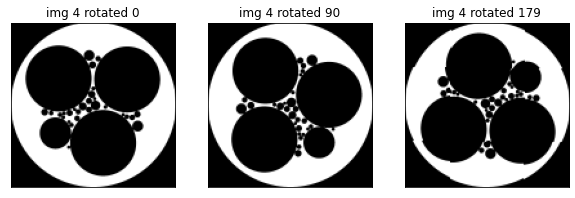

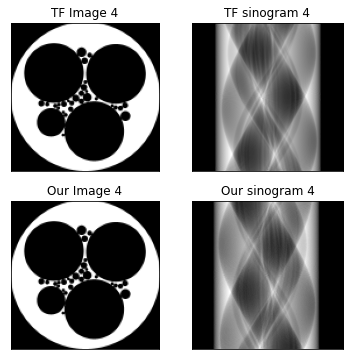

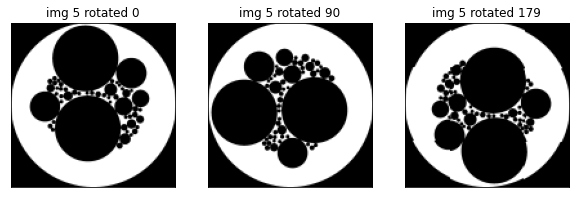

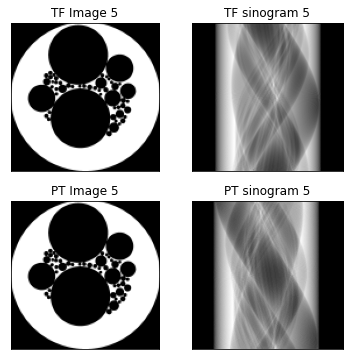

True
testing without PAT
final test if it all work


In [1]:
### Author: Gary Chen
### Date: June 13, 2023
### Last Updated: Jun 15, 2023
### Description: Radon Transform (img to sinogram)
###     There's still some bug; 
###     The sinograms look like a sinograms but the second col arent the same.

try:
    import numpy as np
except Exception as e:
    print("numpy Importing exception")
try:
    import matplotlib.pyplot as plt
except Exception as e:
    print("matplotlib Importing exception")
try:
    import torch
except Exception as e:
    print("torch Importing exception")  
try:
    import torchvision.transforms.functional as F
except Exception as e:
    print("torch Importing exception")  
from torchvision import transforms

#%time # on Jupyter Notebook

class Data_loader:
    # load .npy file into PyTorch tensor and move it to GPU
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def npy_to_tensor(self, npy_file_path):
        np_data = np.load(npy_file_path)
        tensor = torch.from_numpy(np_data).to(self.device)
        return tensor


class Radon_Transform:
    # convert the img to sinogram
    def __init__(self):
        self.theta_num = 180
        
    def img_to_rotated_imgs(self, image):
        # initialize the collection of rotated iamges as 180 by 128 by 128 empty arrays
        rotated_imgs = torch.zeros((self.theta_num,128, 128))
        # assign the unrotated img as the first img in the rotated collection
        rotated_imgs[0,:,:] = image
        for i in range(1,theta_num):
            rotated_image = F.rotate(image.unsqueeze(0), float(i)) #rotate function requires img in 3-d dimension
            rotated_imgs[i,:,:] = rotated_image
        return rotated_imgs
    
    def rotated_imgs_to_sinogram(self, rotated_images):
        # initialize the summing vector
        sum_vec = torch.ones((size_x, 1))
        sinogram = torch.zeros((180, 184))
        for i in range(theta_num):
            # ith_p is the i-th row of the sinogram corresponding to each angle
            ith_p = torch.matmul(rotated_images[i,:,:],sum_vec)/180 # 128 by 128 @ 128 by 1 means sum across the all rows of the img
            # Calculate start index for ith row in the sinogram 
            start = (sinogram.shape[0] - ith_p.shape[0]) // 2
            # Assign p values to the ith row of the sinogram, centered
            sinogram[i,start:start+ith_p.shape[0]] = ith_p.reshape(-1)
        return sinogram 

class Display_Image:
    # display the images and sinograms and compare our implementations with CT-PVAE
    
    def display_rotated_imgs(self, rotated_images, img_id):
        rotate_fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        ax[0].imshow(rotated_images[0,:,:].cpu().numpy(), cmap='gray')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title(f'img {img_id} rotated 0')
        ax[1].imshow(rotated_images[90,:,:].cpu().numpy(), cmap='gray')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title(f'img {img_id} rotated 90')
        ax[2].imshow(rotated_images[179,:,:].cpu().numpy(), cmap='gray')
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].set_title(f'img {img_id} rotated 179')
        rotate_fig.savefig(f"rotate images {img_id}")
        plt.show()
    
    def display_radon_transform(self, img, img_id, tf_sinogram,pt_sinogram):
        # Create a figure and a 1x2 subplot grid
        fig, axs = plt.subplots(2, 2, figsize=(6, 6))
        axs[0,0].imshow(img.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[0,0].set_title(f'TF Image {img_id}')
        axs[0,1].imshow(tf_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[0,1].set_title(f'TF sinogram {img_id}')
        axs[1,0].imshow(img.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[1,1].imshow(pt_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[1,0].set_title(f'PT Image {img_id}')
        axs[1,1].set_title(f'PT sinogram {img_id}')

        # Remove the x and y ticks
        axs[0,0].set_xticks([])
        axs[0,0].set_yticks([])
        axs[0,1].set_xticks([])
        axs[0,1].set_yticks([])
        axs[1,0].set_xticks([])
        axs[1,0].set_yticks([])
        axs[1,1].set_xticks([])
        axs[1,1].set_yticks([])
        
        fig.savefig(f"radon comp {img_id}")
        plt.show()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

img_id = 4 # adjust this id from 0 to 50 for any images in the dataset
# Load the images and sinograms .npy file to tensor on cuda
images = np.load('foam_training.npy')
images_tensor = torch.from_numpy(images).to(device)
print("images shape", images_tensor.shape)
image1 = images_tensor[img_id,:,:]
print("image1 shape", image1.shape)
print("image1 dtpye", image1.dtype)

sinograms = np.load('x_train_sinograms.npy')
sinograms_tensor = torch.from_numpy(sinograms).to(device)
print("sinograms shape", sinograms.shape)
sinogram1 = sinograms_tensor[img_id,:,:]
print("sinogram shape", sinogram1.shape)
print("sinogram dtpye", sinogram1.dtype)


#hyperparameters
t_num = 184 # pixel number on the discretized detector
theta_num = 180 # number of projections
size_x = image1.shape[0]
size_y = image1.shape[1]

#initialize sinogram as a black img
mysinogram = torch.zeros((180, 184))

# initialize the collection of rotated iamges as 180 by 128 by 128 empty arrays
rotated_imgs = torch.zeros((theta_num,128, 128))
# assign the unrotated img as the first img in the rotated collection

rotated_imgs[0,:,:] = image1


for i in range(1,theta_num):
    rotated_image = F.rotate(image1.unsqueeze(0), float(i)) #rotate function requires img in 3-d dimension
    rotated_imgs[i,:,:] = rotated_image


# initialize the summing vector
sum_vec = torch.ones((size_x, 1))
print(f"sum_vec has shape {sum_vec.shape}")
for i in range(theta_num):
    # ith_p is the i-th row of the sinogram corresponding to each angle
    ith_p = torch.matmul(rotated_imgs[i,:,:],sum_vec)/180 # 128 by 128 @ 128 by 1 means sum across the all rows of the img
    # Calculate start index for ith row in the sinogram 
    start = (mysinogram.shape[0] - ith_p.shape[0]) // 2
    # Assign p values to the ith row of the sinogram, centered
    mysinogram[i,start:start+ith_p.shape[0]] = ith_p.reshape(-1)

# Display images for radon transform

# create figure for intermediate visualization
rotate_fig, ax = plt.subplots(1, 3, figsize=(10, 6))
ax[0].imshow(rotated_imgs[0,:,:].cpu().numpy(), cmap='gray')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(f'img {img_id} rotated 0')
ax[1].imshow(rotated_imgs[90,:,:].cpu().numpy(), cmap='gray')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f'img {img_id} rotated 90')
ax[2].imshow(rotated_imgs[179,:,:].cpu().numpy(), cmap='gray')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title(f'img {img_id} rotated 179')

# Create a figure and a 1x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0,0].imshow(image1.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
axs[0,0].set_title(f'TF Image {img_id}')
axs[0,1].imshow(sinogram1.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
axs[0,1].set_title(f'TF sinogram {img_id}')
axs[1,0].imshow(image1.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
axs[1,1].imshow(mysinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
axs[1,0].set_title(f'Our Image {img_id}')
axs[1,1].set_title(f'Our sinogram {img_id}')

# Remove the x and y ticks
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])

# Display the figure
fig.savefig("radon comp")
rotate_fig.savefig("rotate images")

plt.show()

data_loader = Data_loader()
radon_tranformer = Radon_Transform()
displayer = Display_Image()
img_id = 2
images_tensor = data_loader.npy_to_tensor('foam_training.npy')
tf_sinograms_tensor = data_loader.npy_to_tensor('x_train_sinograms.npy')
for img_id in range(5,6):
    image = images_tensor[img_id,:,:]
    rotated_images = radon_tranformer.img_to_rotated_imgs(image)
    pt_sinogram = radon_tranformer.rotated_imgs_to_sinogram(rotated_images)
    tf_sinogram = tf_sinograms_tensor[img_id,:,:]
    displayer.display_rotated_imgs(rotated_images, img_id)
    displayer.display_radon_transform(image, img_id, tf_sinogram,pt_sinogram)
#print("images shape", images_tensor.shape)
#print("image1 shape", image1.shape)
#print("image1 dtpye", image1.dtype)
#print("tf_sinograms_tensor shape", tf_sinograms_tensor.shape)
#print("tf_sinogram shape", tf_sinogram.shape)
#print("tf_sinogram dtpye", tf_sinogram.dtype)

# testing across machines

print(torch.cuda.is_available())
print('testing without PAT')
print('final test if it all work')

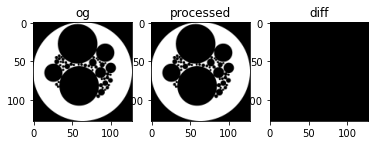

In [16]:
rotate_angle = 90
a = rotated_images[0]
b = rotated_images[rotate_angle]
c = F.rotate(b.unsqueeze(0),rotate_angle+180)
c = c.reshape(128,128)
def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image2.cpu().numpy()-image1.cpu().numpy(), cmap='gray')
    '''
    print('img 1 is', image1[50:60, 50:60])
    print('img 2 is', image2[50:60, 50:60])
    print('diff is', image2.cpu().numpy()[50:60, 50:60]-image1.cpu().numpy()[50:60, 50:60])
    '''
    axs[2].set_title('diff')
    plt.show()
plot_2_img_tensor(a,c,'og','processed')